<a href="https://colab.research.google.com/github/rmib200/BrainTumor-Classification-Tensorflow-to-ONNX/blob/main/BrainTumor_Tensorflow_Classification_ONNX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification (Tensorflow to ONNX)
<p align='center'><img src='https://github.com/rmib200/BrainTumor-Classification-Tensorflow-to-ONNX/blob/main/brain_tumor_dataset.png?raw=True'/></p>

In [5]:
!pip install keras2onnx
!pip install tensorflow tf2onnx
!pip install onnxruntime
!unrar x -Y /content/brain_tumor_dataset.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/brain_tumor_dataset.rar

Creating    brain_tumor_dataset                                       OK
Creating    brain_tumor_dataset/no                                    OK
Extracting  brain_tumor_dataset/no/1 no.jpeg                               0%  OK 
Extracting  brain_tumor_dataset/no/10 no.jpg                               0%  OK 
Extracting  brain_tumor_dataset/no/11 no.jpg                               0%  OK 
Extracting  brain_tumor_dataset/no/12 no.jpg                               0%  OK 
Extracting  brain_tumor_dataset/no/13 no.jpg                               0%  OK 
Extracting  brain_tumor_dataset/no/14 no.jpg                               0%  OK 
Extracting  brain_tumor_dataset/no/15 no.jpg                               1%  OK 
Extracting  brain_tumor_dataset/no/17 no.jpg                               1%  OK 

In [10]:
#Creating folders for the resized image file
!mkdir new_brain_tumor_dataset
!mkdir new_brain_tumor_dataset/train
!mkdir new_brain_tumor_dataset/test

In [6]:
#imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid') #Seaborn style
from numpy.random import seed
seed(1) #reproducible tensorflow
tf.random.set_seed(2)

In [7]:
#defining the CNN
def build_model():

   input_shape = (240,240,1)
   num_classes = 2
   model = tf.keras.Sequential(
       [
           tf.keras.Input(shape=input_shape),
           tf.keras.layers.Conv2D(32, kernel_size=(3, 3),padding="valid", activation="relu"),
           tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),
           tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="valid",activation="relu"),
           tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding="valid"),
           tf.keras.layers.Flatten(),
           tf.keras.layers.Dropout(0.5),
           tf.keras.layers.Dense(num_classes, activation="sigmoid"),
       ]
   )
   return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 238, 238, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 215296)            0         
                                                                 
 dropout_1 (Dropout)         (None, 215296)           

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


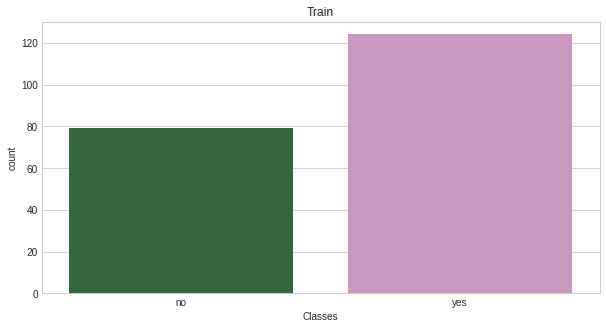

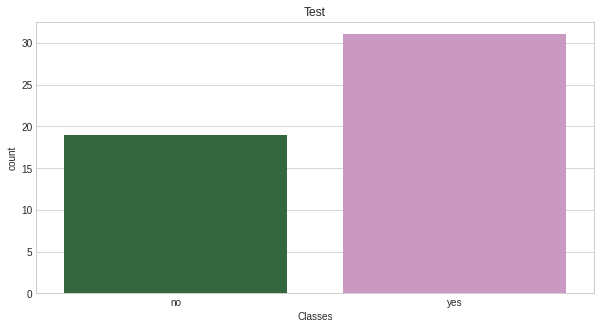

In [8]:
#use keras to load the images
def load_images(path, data_aug=False):
  from keras.preprocessing.image import ImageDataGenerator
  #using Data Augmentation for Train Set
  if data_aug == True:
    datagen_train = ImageDataGenerator(rescale=1./255, zoom_range=[0.5,1.0], width_shift_range=[-100,100],validation_split=0.2)
  else:
    datagen_train = ImageDataGenerator(rescale=1./255,validation_split=0.2)
  datagen_test = ImageDataGenerator(rescale=1./255)


  train = datagen_train.flow_from_directory(path, class_mode="categorical", color_mode = "grayscale", subset="training", target_size = (240, 240), save_to_dir="/content/new_brain_tumor_dataset/train", save_format = "jpg")
  val = datagen_train.flow_from_directory(path, class_mode="categorical", color_mode = "grayscale", subset="validation", target_size = (240, 240), save_to_dir="/content/new_brain_tumor_dataset/test", save_format = "jpg")

  return train, val


def plot_classes(data, title):
  #function to plot classes
  plt.figure(figsize=(10,5))
  import seaborn as sns
  labels = data.class_indices.keys()
  ax = sns.countplot(x=data.classes, palette="cubehelix")
  ax.set_xlabel("Classes")
  ax.set_xticklabels(labels)
  ax.set_title(title)
  plt.show()


path = "/content/brain_tumor_dataset"
train_images, val_images = load_images(path)

plot_classes(train_images, "Train")
plot_classes(val_images, "Test")

In [11]:
train_images.next()
val_images.next()

(array([[[[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         ...,
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]]],
 
 
        [

In [12]:
#metric plots
def plot_learning_curves(history):
  fig, ax = plt.subplots(2,1,sharex=False, figsize=(10,8))
  plt.tight_layout(h_pad=4.0)
  ax[0].plot(history.history["accuracy"], "-o", label="Training")
  ax[0].plot(history.history["val_accuracy"], "-o", label="Validation")
  ax[0].set_xlabel("Epochs")
  ax[0].legend()
  # ax[0].plot(history.history["loss"], "-o")
  ax[0].set_title("Accuracy")
  ax[1].plot(history.history["loss"], "-o", label="Training")
  ax[1].plot(history.history["val_loss"], "-o", label="Validation")
  ax[1].set_title("Loss")
  ax[1].set_xlabel("Epochs")
  ax[1].legend()
  plt.show();

def get_y_values(model, val):
  y_pred = model.predict(val)
  # print("Len y_pred:",len(y_pred))
  y_pred
  y_pred_= np.argmax(y_pred, axis=1)
  print("Len y_pred",len(y_pred_))
  y_pred_
  y_true = val.classes
  print("Len y_true", len(y_true.tolist()))
  return y_true, y_pred_

def plot_cm(y_test, y_pred, data):
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
  labels = data.class_indices.keys()
  print(cm)
  # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
  import seaborn as sns
  plt.figure(figsize=(8,5))
  plt.title("Confusion Matrix")
  sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot=True, fmt="g")
  plt.xlabel("True")
  plt.ylabel("Predicted");
  plt.show();

def plot_roc_curve(y_test, y_pred):
  import pandas as pd
  from sklearn.metrics import roc_curve
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred, pos_label=1)
  from sklearn.metrics import auc
  auc_keras = auc(fpr_keras, tpr_keras)
  import matplotlib.pyplot as plt
  from sklearn.metrics import roc_auc_score
  keras_roc_auc = roc_auc_score(y_test, y_pred)
  # keras_roc_auc = roc_auc_score(y_test, pd.get_dummies(y_pred), multi_class="ovr")
  # plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.figure(figsize=(8,5))
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = %0.2f)' % keras_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right");
  plt.show();

In [14]:
train_images.image_shape

(240, 240, 1)

In [15]:
val_images.image_shape

(240, 240, 1)

# Training the CNN with the fMRI images

Epoch 1/30
7/7 [==============================] - 13s 401ms/step - loss: 0.8045 - accuracy: 0.6010 - val_loss: 0.5155 - val_accuracy: 0.7400
Epoch 2/30
7/7 [==============================] - 2s 281ms/step - loss: 0.4937 - accuracy: 0.7586 - val_loss: 0.4988 - val_accuracy: 0.7400
Epoch 3/30
7/7 [==============================] - 2s 242ms/step - loss: 0.4416 - accuracy: 0.8177 - val_loss: 0.5413 - val_accuracy: 0.7600
Epoch 4/30
7/7 [==============================] - 2s 247ms/step - loss: 0.3880 - accuracy: 0.8621 - val_loss: 0.4996 - val_accuracy: 0.7400
Epoch 5/30
7/7 [==============================] - 2s 255ms/step - loss: 0.3262 - accuracy: 0.8571 - val_loss: 0.4757 - val_accuracy: 0.7400
Epoch 6/30
7/7 [==============================] - 2s 248ms/step - loss: 0.2616 - accuracy: 0.9015 - val_loss: 0.4574 - val_accuracy: 0.7600
Epoch 7/30
7/7 [==============================] - 2s 246ms/step - loss: 0.2041 - accuracy: 0.9113 - val_loss: 0.4980 - val_accuracy: 0.8000
Epoch 8/30
7/7 [===

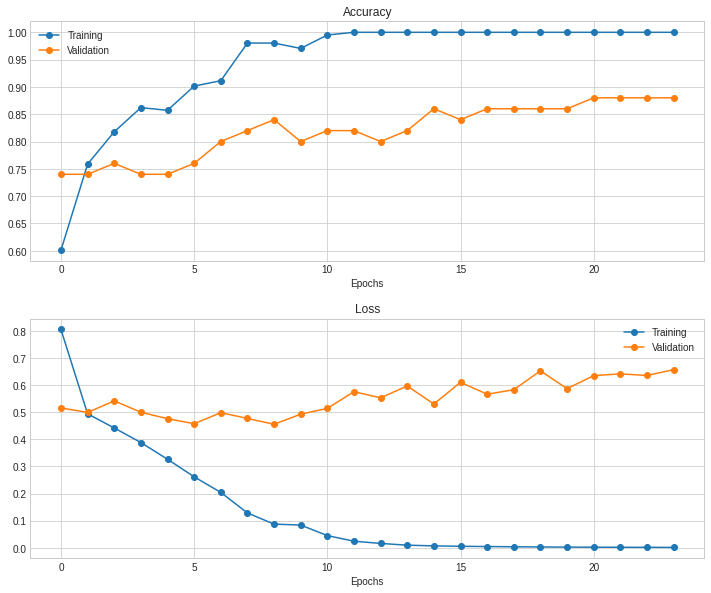

In [16]:
n_batch = 10
sgd = tf.keras.optimizers.SGD(learning_rate = 0.001, decay=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_images, epochs=30, validation_data=val_images, callbacks=es)
plot_learning_curves(history)

Len y_pred 50
Len y_true 50
[[ 7 12]
 [ 6 25]]


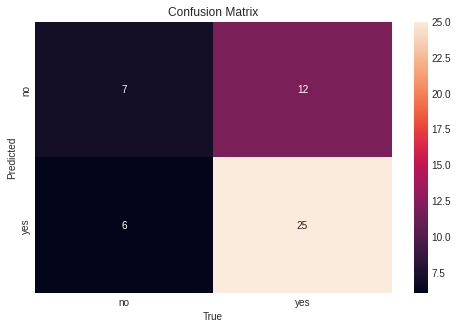

In [17]:
y_test, y_pred = get_y_values(model, val_images)
plot_cm(y_test, y_pred, val_images)
# plot_roc_curve(y_test, y_pred)

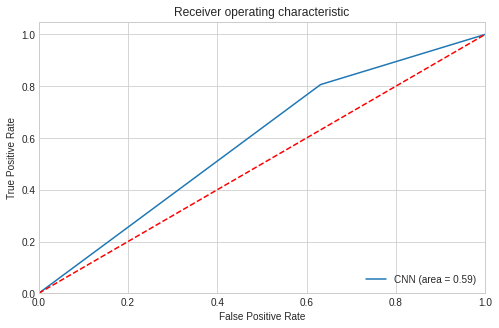

In [18]:
plot_roc_curve(y_test, y_pred)

In [20]:
#saving the model
model.save("brainTumorModel")
model.save('brainTumorModel.h5')

INFO:tensorflow:Assets written to: brainTumorModel/assets


# Exporting the model to ONNX


In [21]:
#https://github.com/onnx/tensorflow-onnx/blob/master/tutorials/keras-resnet50.ipynb
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec((None, 240, 240, 1), tf.float32, name="input"),)
output_path = "brainTumorModel.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [22]:
#Compressing the reszed images from the ImageDataGenerator
!zip -r /content/new_brain_tumor_dataset.zip /content/new_brain_tumor_dataset

Se han truncado las últimas 5000 líneas del flujo de salida.
  adding: content/new_brain_tumor_dataset/train/_115_307204.jpg (stored 0%)
  adding: content/new_brain_tumor_dataset/train/_134_1186518.jpg (stored 0%)
  adding: content/new_brain_tumor_dataset/train/_12_5593831.jpg (deflated 1%)
  adding: content/new_brain_tumor_dataset/train/_201_2136894.jpg (deflated 5%)
  adding: content/new_brain_tumor_dataset/train/_103_1883239.jpg (deflated 0%)
  adding: content/new_brain_tumor_dataset/train/_29_9206726.jpg (deflated 0%)
  adding: content/new_brain_tumor_dataset/train/_127_1093270.jpg (stored 0%)
  adding: content/new_brain_tumor_dataset/train/_193_5656325.jpg (deflated 0%)
  adding: content/new_brain_tumor_dataset/train/_140_7667207.jpg (deflated 0%)
  adding: content/new_brain_tumor_dataset/train/_91_7902940.jpg (deflated 3%)
  adding: content/new_brain_tumor_dataset/train/_73_5861846.jpg (deflated 0%)
  adding: content/new_brain_tumor_dataset/train/_97_9394070.jpg (stored 0%)
  add